# Sprint 機械学習フロー

## 1.このSprintについて


### Sprintの目的
- 機械学習の実践的な流れを知る
- 高い汎化性能を持つモデルを完成させる

### どのように学ぶか
- 丁寧な検証が行える状態にした上で、他者の解法を参考に汎化性能の高いモデル作りを進めます。

## 2.機械学習フロー

Kaggleの Home Credit Default Risk コンペティションを題材に、機械学習の実践的な流れを学びます。特に適切な 検証 を行い、高い 汎化性能 のあるモデルを完成させることを目指します。

<a href="https://www.kaggle.com/c/home-credit-default-risk" style="text-decoration:none">
Home Credit Default Risk | Kaggle
</a>

## 【問題1】クロスバリデーション

事前学習期間では検証データをはじめに分割しておき、それに対して指標値を計算することで検証を行っていました。（ホールドアウト法）しかし、分割の仕方により精度は変化します。実践的には クロスバリデーション（交差検証） を行います。分割を複数回行い、それぞれに対して学習と検証を行う方法です。複数回の分割のためにscikit-learnにはKFoldクラスが用意されています。

事前学習期間の課題で作成したベースラインモデルに対してKFoldクラスによるクロスバリデーションを行うコードを作成し実行してください。

<a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold" style="text-decoration:none">
sklearn.model_selection.KFold — scikit-learn 0.21.3 documentation
</a>

In [1]:
# google colab環境用
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# pip install lightgbm

In [3]:
# pip install optuna

In [4]:
# Numpy
import numpy as np
import numpy.random as random

# Dataframe operations
import pandas as pd

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Scalers
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Data Split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# Cross-validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit

# Tuning parameters
from sklearn.model_selection import GridSearchCV

# Linear-models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.svm import LinearSVC

# Dicision Tree
# import pydotplus
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn import datasets
from IPython.display import Image

# Random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

# LightGBM
from lightgbm import LGBMClassifier
import lightgbm as lgb

# Bayesian Optimization
import optuna

# Evaluation
from sklearn import metrics

# garbage collection
import gc

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [5]:
# トレーニングデータの取得
df = pd.read_csv("../../data/home-credit-default-risk/application_train.csv")
# df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/home-credit-default-risk/application_train.csv")

# df = df.head(100)
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# テストデータの取得
df_test = pd.read_csv("../../data/home-credit-default-risk/application_test.csv")
# df_test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/home-credit-default-risk/application_test.csv")
df_test01 = df_test.copy()
df_test01.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# 全変全一括変換用関数
def dummy_variable_all(df, sort_frequence=True, dropna=True, map_show=False, skip_column=[]):
    """
    オブジェクト型の変数を数値へ一括変換する処理。
    
    Parameters
    ----------------
    df : pd.DataFrame
      データセットのDataFrame。
    sort_frequence : bool
      数値変換の順番を頻度順にするか
    dropna : bool
      nullを同様に数値へ変換するか
    map_show : bool
      変換するname mapを標準出力するか

    Returns
    ----------------
    df : pd.DataFrame
    """
    
    for column_name in df:
        if np.dtype(df[column_name]) == 'object' and column_name not in skip_column:
            if sort_frequence:
                unique_value = df[column_name].value_counts(dropna=dropna).sort_values(ascending=False).index
            else:
                unique_value = df[column_name].value_counts(dropna=dropna).sort_index().index

            name_map = {}
            for i, value in enumerate(unique_value):
                name_map[value] = i
            if map_show:
                print('column_name :', column_name)
                print('replace :', name_map)
            df[column_name] = df[column_name].map(name_map)
        else:
            pass
    return df

In [8]:
print("カテゴリ変数を以下のように置換")
df2 = dummy_variable_all(df.copy(), dropna=False, map_show=True)
df2_test = dummy_variable_all(df_test.copy(), dropna=False, map_show=False)

カテゴリ変数を以下のように置換
column_name : NAME_CONTRACT_TYPE
replace : {'Cash loans': 0, 'Revolving loans': 1}
column_name : CODE_GENDER
replace : {'F': 0, 'M': 1, 'XNA': 2}
column_name : FLAG_OWN_CAR
replace : {'N': 0, 'Y': 1}
column_name : FLAG_OWN_REALTY
replace : {'Y': 0, 'N': 1}
column_name : NAME_TYPE_SUITE
replace : {'Unaccompanied': 0, 'Family': 1, 'Spouse, partner': 2, 'Children': 3, 'Other_B': 4, nan: 5, 'Other_A': 6, 'Group of people': 7}
column_name : NAME_INCOME_TYPE
replace : {'Working': 0, 'Commercial associate': 1, 'Pensioner': 2, 'State servant': 3, 'Unemployed': 4, 'Student': 5, 'Businessman': 6, 'Maternity leave': 7}
column_name : NAME_EDUCATION_TYPE
replace : {'Secondary / secondary special': 0, 'Higher education': 1, 'Incomplete higher': 2, 'Lower secondary': 3, 'Academic degree': 4}
column_name : NAME_FAMILY_STATUS
replace : {'Married': 0, 'Single / not married': 1, 'Civil marriage': 2, 'Separated': 3, 'Widow': 4, 'Unknown': 5}
column_name : NAME_HOUSING_TYPE
replace : {'Hous

In [9]:
# 置換後のデータタイプ確認
df2.dtypes.value_counts()

float64    65
int64      57
dtype: int64

In [10]:
df2.fillna(df2.median(), inplace=True)
df2_test.fillna(df2.median(), inplace=True)
df2.head()
df2_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,0,0,0,0,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,0,1,0,0,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,0,1,1,0,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,0,0,0,0,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,0,1,1,1,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


In [11]:
# 欠損がないことを確認
df2.isnull().sum().sort_values()

SK_ID_CURR                    0
TOTALAREA_MODE                0
HOUSETYPE_MODE                0
FONDKAPREMONT_MODE            0
NONLIVINGAREA_MEDI            0
                             ..
REG_REGION_NOT_LIVE_REGION    0
HOUR_APPR_PROCESS_START       0
WEEKDAY_APPR_PROCESS_START    0
REGION_RATING_CLIENT          0
AMT_REQ_CREDIT_BUREAU_YEAR    0
Length: 122, dtype: int64

In [12]:
# 少しでもデータを軽くしたいため、
# 以前の課題で使用したカラムのみを使用
use_columns = ['SK_ID_CURR', 'TARGET', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       'FLAG_WORK_PHONE', 'FLAG_PHONE', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS',
       'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_2',
       'EXT_SOURCE_3', 'FONDKAPREMONT_MODE', 'WALLSMATERIAL_MODE',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_3',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'EXT_SOURCE_1', 'OWN_CAR_AGE']


In [13]:
df3 = df2[use_columns].copy()
use_columns.remove('TARGET')
df3_test = df2_test[use_columns].copy()
# df3 = df3.head(500)
df3.head()
df3_test.head()

,SK_ID_CURR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_EDUCATION_TYPE,...,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,EXT_SOURCE_1,OWN_CAR_AGE
0,100001,0,0,0,135000.0,568800.0,20560.5,450000.0,0,1,...,0.0,0.0,0.0,-1740.0,1,0.0,0.0,0.0,0.752614,9.0
1,100005,1,0,0,99000.0,222768.0,17370.0,180000.0,0,0,...,0.0,0.0,0.0,0.0,1,0.0,0.0,3.0,0.564990,9.0
2,100013,1,1,0,202500.0,663264.0,69777.0,630000.0,3,1,...,0.0,0.0,0.0,-856.0,0,0.0,1.0,4.0,0.505998,5.0
3,100028,0,0,0,315000.0,1575000.0,49018.5,1575000.0,0,0,...,0.0,0.0,0.0,-1805.0,1,0.0,0.0,3.0,0.525734,9.0
4,100038,1,1,1,180000.0,625500.0,32067.0,625500.0,0,0,...,0.0,0.0,0.0,-821.0,1,0.0,0.0,1.0,0.202145,16.0


In [14]:
def classification_model(df, 
                         y_column_name,
                         algorithm='LogisticRegression',
                         test_size=0.3, 
                         random_state=None, 
                         standardization=False,
                         scaling_func=None,
                         roc=False, 
                         confusion=True, 
                         pos_label=None,
                         cross_val=False,
                         grid_search=False,
                         cross_val_splits=5,
                         param_grid=None):
    
    # 使用可能なモデルのリスト
    algorithm_list = ['LogisticRegression',
                      'LinearSVC', 
                      'DecisionTreeClassifier',
                      'RandomForestClassifier',
                      'LGBMClassifier']

    
    # 引数不正チェック
    assert algorithm in algorithm_list, "[ERROR] An invalid value is specified for the 'algorithm' parameter."
    assert roc or confusion, "[ERROR] Either 'roc' or 'confusion' parameter must be True."    
    
    # データを説明変数と目的変数へ分割
    x = df.drop(y_column_name, axis=1)
    y = df.loc[:, y_column_name]
    
    # ホールドアウト検証
    print('[INFO] Running train_test_split (test_size = {},  random_state = {})'.format(test_size, random_state))
    if random_state != None:
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state)
    else:
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size)      
        
    # スケーリング
    # カスタム
    if scaling_func != None:
        print('[INFO] Running custom scaling function...')
        scaling_func(x_train, x_test)
    
    # 標準化
    elif standardization:
        scaler = StandardScaler()
        scaler.fit(x_train)
        x_train = scaler.transform(x_train)
        x_test = scaler.transform(x_test)
    
    # クラス初期化
    print('\n[INFO] ' + algorithm + ' instance generation')
    if algorithm == algorithm_list[0]:
        model = LogisticRegression()
    elif algorithm == algorithm_list[1]:
        model = LinearSVC()
    elif algorithm == algorithm_list[2]:
        model = DecisionTreeClassifier()
    elif algorithm == algorithm_list[3]:
        model = RandomForestClassifier()
    elif algorithm == algorithm_list[4]:
        model == LGBMClassifier()
    # クロスバリデーション（KFold）
    if cross_val and not grid_search:
        print('\n[INFO] Running cross-validation...')
        kf = KFold(n_splits=cross_val_splits, shuffle=False, random_state=random_state)
        if roc:
            scores = cross_val_score(model, x_train, y_train, cv=kf, scoring='roc_auc')
        else:
            scores = cross_val_score(model, x_train, y_train, cv=kf)
        # 表示
        print('[INFO] Cross-validation socres')
        print(' - Cross-validation scores : {}'.format(scores))
        print(' - Average cross-validation score : {}'.format(scores.mean())) 
        
    # グリッドサーチCV
    if grid_search:
        # ロジスティック回帰のパラメータグリッド
        if param_grid is None:
            if algorithm == 'LogisticRegression':
                param_grid = {'C': [0.0001, 0.001, 0.01, 0.1, 1.0],
                              'intercept_scaling': [0.001, 0.01, 0.1, 1], 
                              'penalty': ['l2'],
                              'solver': ['liblinear'],
                              'tol': [0.1, 0.01, 0.001, 0.0001, 0.000001], 
                              'warm_start': ['True', 'False']}
            # ランダムフォレストのパラメータグリッド
            elif algorithm == 'RandomForestClassifier':
                param_grid = {'n_estimators': [120, 300, 500, 800, 1200],
                              'max_depth': [5, 8, 15, 25, 30, None],
                              'min_samples_split': [2, 5, 10, 15, 100],
                              'min_samples_leaf': [2, 5, 10],
                              'max_features': ['Log2', 'sqrt']
                             }
        # グリッドサーチ
        if roc:
            model = GridSearchCV(model, param_grid, cv=cross_val_splits, scoring="roc_auc")
        else:
            model = GridSearchCV(model, param_grid, cv=cross_val_splits)


    # トレーニングデータで学習
    print('\n[INFO] Learning by ' + algorithm + '...')
    model.fit(x_train, y_train)
    print('[INFO]', model)
    
    # グリッドサーチの評価スコア
    if grid_search:
        print('\n[INFO] GridSearchCV scores')
        print(' - Best cross validation score : {}'.format(model.best_score_))
        print(' - Best parameterrs : {}'.format(model.best_params_))
        print(' - Train best score : {}'.format(model.best_score_))
        print(' - Test score : {}'.format(model.score(x_test, y_test)))

    # グリッドサーチの交差検証の結果解析
    if grid_search:
        results = pd.DataFrame(model.cv_results_)
        display(results)

    # 予測
    if roc:
        y_pred = model.predict_proba(x_test)
        y_pred_train = model.predict_proba(x_train)
    if confusion:
        y_pred = model.predict(x_test)
        y_pred_train = model.predict(x_train)
        
        
    # 評価
    # AUC・ROC曲線
    if roc:
        # AUC
        fpr, tpr, thres = metrics.roc_curve(y_test, y_pred[:, 1])
        auc = metrics.auc(fpr, tpr)
        score = auc
        print('[INFO] auc:', auc)
        # ROC曲線
        plt.figure(figsize = (5, 5), facecolor='w') #単一グラフの場合のサイズ比の与え方
        plt.plot(fpr, tpr, marker='o')
        plt.xlabel('FPR: False Positive Rete', fontsize = 13)
        plt.ylabel('TPR: True Positive Rete', fontsize = 13)
        plt.grid(True, alpha=.5)
        plt.show()
        
    # 精度表示と混同行列
    if confusion:
        def model_score(y, y_pred):
            # 精度を表示
            values = {'Accuracy ':0, 'Precision':0, 'Recall   ':0, 'F        ':0}
            if pos_label == None:
                values['Accuracy '] = metrics.accuracy_score(y, y_pred)   # Accuracy（正解率）
                values['Precision'] = metrics.precision_score(y, y_pred) # Precision（適合率）
                values['Recall   '] = metrics.recall_score(y, y_pred)       # Recall（再現率）
                values['F        '] = metrics.f1_score(y, y_pred)                # F値
            else:
                values['Accuracy '] = metrics.accuracy_score(y, y_pred)   # Accuracy（正解率）
                values['Precision'] = metrics.precision_score(y, y_pred, pos_label=pos_label) # Precision（適合率）
                values['Recall   '] = metrics.recall_score(y, y_pred, pos_label=pos_label)       # Recall（再現率）
                values['F        '] = metrics.f1_score(y, y_pred, pos_label=pos_label)                # F値  
            for key, value in values.items():
                print("{} : {:.3f}".format(key, value))
        print('\n[INFO] Training data accuracy')
        model_score(y_train, y_pred_train)
        print('\n[INFO] Test data accuracy')
        model_score(y_test, y_pred)
        
        # 混同行列を表示
        confusion_df = pd.DataFrame(confusion_matrix(y_test, y_pred), index=[0,1], columns=[0,1])
        plt.figure(figsize=(5, 3))
        sns.heatmap(confusion_df, cmap='Pastel1', cbar=False, annot_kws={"size": 22}, annot=True, fmt="d", linewidths=1)
        plt.title("Confusion-matrix", fontsize=14)
        plt.xlabel("Predicted value", fontsize=12)
        plt.ylabel("Observed value", fontsize=12)
        plt.show()
        
        
    # 重要度を抽出・可視化
    if algorithm in ['DecisionTreeClassifier', 'RandomForestClassifier']:
        if param_grid:
            importances = model.best_estimator_.feature_importances_
        else:
            importances = model.feature_importances_
        ser_importances = pd.Series(importances, index=x_train.columns).sort_values(ascending=True)
        with plt.style.context('classic'):
            plt.figure(figsize=(10,int(df.shape[1]/4.5)), facecolor='w')
            plt.barh(ser_importances.index,
                    ser_importances,
                    align='center',
                    color='red',
                    alpha=.5
                    )
            plt.title('Feature importances')
            plt.xlabel('Importances')
            plt.ylabel('Feature value')
            plt.grid(True)
            plt.show()

    return model, y_pred, ser_importances

[INFO] Running train_test_split (test_size = 0.3,  random_state = None)

[INFO] RandomForestClassifier instance generation

[INFO] Running cross-validation...
[INFO] Cross-validation socres
 - Cross-validation scores : [0.71681301 0.71578325 0.7159968 ]
 - Average cross-validation score : 0.7161976885971137

[INFO] Learning by RandomForestClassifier...
[INFO] RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
[INFO] auc: 0.71206846335054


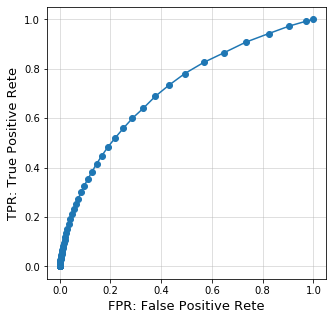

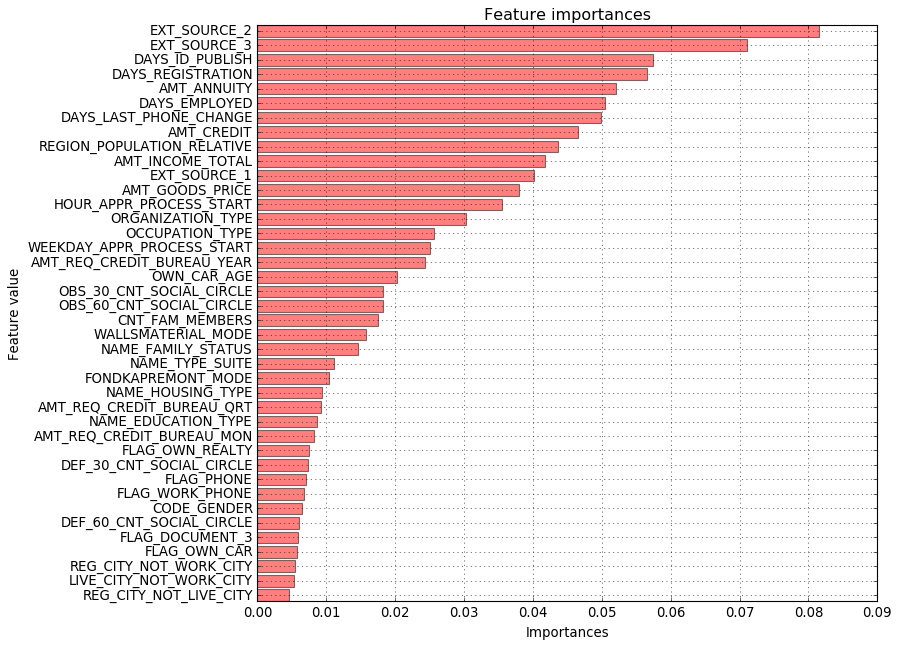

In [16]:
model01, y_pred01, importances01 = classification_model(df3.drop('SK_ID_CURR', axis=1), 
                                         'TARGET', 
                                         algorithm='RandomForestClassifier', 
                                         roc=True, 
                                         confusion=False,
                                         standardization=False,
                                         cross_val_splits=3,
                                         cross_val=True)

## 【問題2】グリッドサーチ

これまで分類器のパラメータには触れず、デフォルトの設定を使用していました。パラメータの詳細は今後のSprintで学んでいくことになります。機械学習の前提として、パラメータは状況に応じて最適なものを選ぶ必要があります。最適なパラメータを探していくことを パラメータチューニング と呼びます。パラメータチューニングをある程度自動化する単純な方法としては グリッドサーチ があります。

scikit-learnのGridSearchCVを使い、グリッドサーチを行うコードを作成してください。そして、ベースラインモデルに対して何らかしらのパラメータチューニングを行なってください。どのパラメータをチューニングするかは、使用した手法の公式ドキュメントを参考にしてください。

<a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html" style="text-decoration">
sklearn.model_selection.GridSearchCV — scikit-learn 0.21.3 documentation
</a>
    
GridSearchCVクラスには引数としてモデル、探索範囲、さらにクロスバリデーションを何分割で行うかを与えます。クロスバリデーションの機能も含まれているため、これを使用する場合はKFoldクラスを利用する必要はありません。

### ハイパーパラメータの種類
- bootstrap : 復元抽出の有無（ブートストラップサンプリング）
- n_estimators : ランダムフォレストで作成する決定木の数
- criterion : ジニ係数・エントロピーなどの不純度の指標
- max_depth : 決定木の深さ  ※Noneの場合は不純度が0、つまり完全に分類できるまで学習する
- min_samples_split : 整数または小数を指定．デフォルトは None．ノードを分割するために必要な最小サンプルサイズ．整数を指定した場合，その数，小数を指定した場合，全サンプルサイズに対する割合個．
- min_samples_leaf : 整数か小数で指定．デフォルトは1．葉を構成するのに必要な最小限のサンプルの数．整数を指定した場合，その数．小数を指定した場合，元々のサンプルサイズに占める割合と解釈される．
- max_features : 整数，小数，文字列または None を指定．デフォルトは None．最適な分割をするために考慮するフィーチャーの数を指定．整数を指定した場合，その個数，小数の場合全フィーチャーに対する割合個，auto を指定した場合，フィーチャー数のルート個，log2 を指定した場合，log2(フィーチャー数) 個．基本は None を使うべき．
- random_state : 乱数のシード

<a href="https://data-science.gr.jp/implementation/iml_sklearn_random_forest.html" style="text-decoration:none">詳細はこちら</a>

In [17]:
# param_grid = {'n_estimators': [120, 300, 500],
#               'max_depth': [5, 8, 15, None],
#               'min_samples_split': [2, 5, 10, 15],
#               'min_samples_leaf': [2, 5, 10],
#               'max_features': ['log2', 'sqrt']
#              }

param_grid = {'n_estimators': [300],
              'max_depth': [6, 7],
              'min_samples_split': [10],
              'min_samples_leaf': [10],
              'max_features': [None]
             }

[INFO] Running train_test_split (test_size = 0.3,  random_state = None)

[INFO] RandomForestClassifier instance generation

[INFO] Learning by RandomForestClassifier...
[INFO] GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
               

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,297.762487,24.573401,2.216941,0.452464,6,None,10,10,300,"{'max_depth': 6, 'max_features': None, 'min_sa...",0.719787,0.727412,0.723421,0.723540,0.003114,2
1,333.108972,23.715811,1.920288,0.129356,7,None,10,10,300,"{'max_depth': 7, 'max_features': None, 'min_sa...",0.723853,0.731072,0.727278,0.727401,0.002948,1


[INFO] auc: 0.7284866928492622


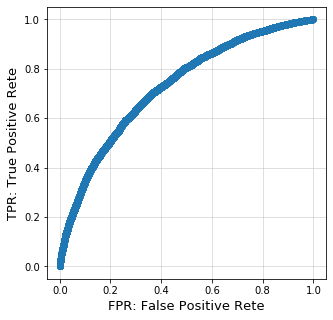

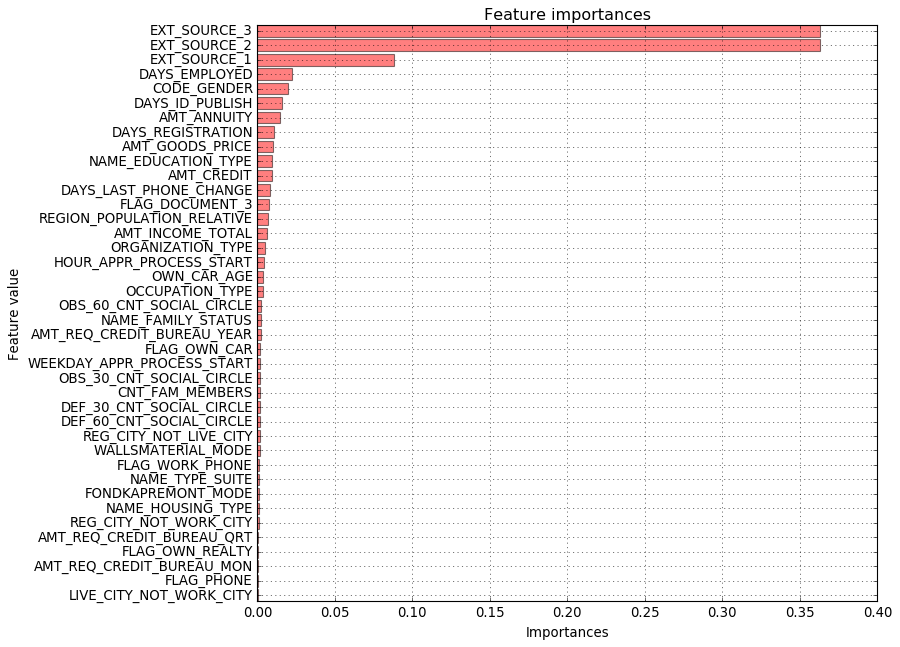

In [18]:
model02, y_pred02, importances02 = classification_model(df3.drop('SK_ID_CURR', axis=1), 
                                                        'TARGET', 
                                                        algorithm='RandomForestClassifier',
                                                        roc=True, 
                                                        confusion=False,
                                                        standardization=False,
                                                        cross_val_splits=3,
                                                        grid_search=True,
                                                        param_grid=param_grid)

## 【問題3】Kaggle Notebooksからの調査
KaggleのNotebooksから様々なアイデアを見つけ出して、列挙してください。


【調査結果】※問題4の回答を兼ねています。

問題3でランダムフォレストでクリッドサーチを動かしたが全然終わる気配がなかったため、

また、Kaggleで主流になっているLightGBMへ使用するアルゴリズムを変更。

パラメータの探索に関しては、Kaggleではベイズ最適化を使用している人がいたため、こちも採用。

※ただし、しっかりとした実行は時間を要するため、本課題提出後にも引き続きチューニングをテストしてみます。

ベイズ最適化はoptunaを使用している人がいたため、参考にしてみた。

LightGBMのクロスバリデーションの実装もKaggleを参考にした。

ただし、Kaggleではearly_stoppingを使ってn_estimators=10000でやっている人が多かったが、

私がそれをすると、トレーニングデータへの適合度ばかり上昇して、テストデータのスコアは変化しなかったため、

n_estimators=350と抑え気味にしている。この原因は追って調査する。

【個人メモ】

clf = RandomForestClassifier(
    n_estimators=50,
    criterion='gini',
    max_depth=5,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    bootstrap=True,
    oob_score=False,
    n_jobs=-1,
    random_state=0,
    verbose=0,
    warm_start=False,
    class_weight='balanced'
)

<a href="https://colab.research.google.com/drive/1b6J6dnnBbDdWgKb-3WnkfdfpEJRrrTi1#scrollTo=TPialwedMo3J&line=21&uniqifier=1" style="text-decoration: none">ソース
</a>

model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
    
<a href="https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction" style="text-decoration:none">
ソース
</a>

clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=32,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.04,
            reg_lambda=0.073,
            min_split_gain=0.0222415,
            min_child_weight=40,
            silent=-1,
            verbose=-1
            )

<a href="https://www.kaggle.com/dromosys/fork-of-fork-lightgbm-with-simple-features-cee847" style="text-decoration:none">
ソース
</a>

In [21]:
# X = df3.drop(['SK_ID_CURR', 'TARGET'], axis=1)
# y = df3['TARGET']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


# # データセットを登録
# lgb_train = lgb.Dataset(X_train, y_train)
# lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)
 
# # LightGBMのハイパーパラメータを設定
# params = {'task': 'train',              # タスクを訓練に設定
#           'boosting_type': 'gbdt',      # GBDTを指定
#           'objective': 'multiclass',    # 多クラス分類を指定
#           'metric': {'multi_logloss'},  # 多クラス分類の損失（誤差）
#           'num_class': 3,               # クラスの数（irisデータセットが3個のクラスなので）
#           'learning_rate': 0.1,         # 学習率
#           'num_leaves': 21,             # ノードの数
#           'min_data_in_leaf': 3,        # 決定木ノードの最小データ数
#           'num_iteration': 100}         # 予測器(決定木)の数:イタレーション
 
# lgb_results = {}                                    # 学習の履歴を入れる入物
# model = lgb.train(params=params,                    # ハイパーパラメータをセット
#                   train_set=lgb_train,              # 訓練データを訓練用にセット
#                   valid_sets=[lgb_train, lgb_test], # 訓練データとテストデータをセット
#                   valid_names=['Train', 'Test'],    # データセットの名前をそれぞれ設定
#                   num_boost_round=100,              # 計算回数
#                   early_stopping_rounds=10,         # アーリーストッピング設定
#                   evals_result=lgb_results)         # 履歴を保存する
 

# loss_train = lgb_results['Train']['multi_logloss']  # 訓練誤差
# loss_test = lgb_results['Test']['multi_logloss']    # 汎化誤差
# best_iteration = model.best_iteration               # 最良の予測器が得られたイタレーション数
# print(best_iteration)


In [22]:
def kfold_lightgbm(df, test_df, num_folds, stratified = False, debug= False):
    
    submission_file_name = 'submission_01.csv'
    
    X_train_df = df.drop('TARGET', axis=1)
    y_train_df = df['TARGET']
    X_test_df = test_df
    
    if stratified:
        folds = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=47)
    else:
        folds = KFold(n_splits=num_folds, shuffle=True, random_state=47)
        
    # スコア格納用の配列用意
    oof_preds = np.zeros(X_train_df.shape[0])
    sub_preds = np.zeros(X_test_df.shape[0])
    feature_importance_df = pd.DataFrame()
       
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train_df, y_train_df)):
        X_train, y_train = X_train_df.iloc[train_idx], y_train_df.iloc[train_idx]
        X_valid, y_valid = X_train_df.iloc[valid_idx], y_train_df.iloc[valid_idx]

        # LightGBM
        clf = LGBMClassifier()

        clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], 
            eval_metric= 'auc', verbose= 1000, early_stopping_rounds= 200)

        oof_preds[valid_idx] = clf.predict_proba(X_valid, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(X_test_df, num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = X_train_df.columns
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, metrics.roc_auc_score(y_valid, oof_preds[valid_idx])))
        del X_train, y_train, X_valid, y_valid
        gc.collect()

    print('Full AUC score %.6f' % metrics.roc_auc_score(y_train_df, oof_preds))
    # 提出ファイル出力
    if not debug:
        X_test_df['TARGET'] = sub_preds
        X_test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    return clf, feature_importance_df


def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')

Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.79994	training's binary_logloss: 0.234098	valid_1's auc: 0.754069	valid_1's binary_logloss: 0.247323
Fold  1 AUC : 0.754069
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.801758	training's binary_logloss: 0.234128	valid_1's auc: 0.749168	valid_1's binary_logloss: 0.247433
Fold  2 AUC : 0.749168
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.799689	training's binary_logloss: 0.233331	valid_1's auc: 0.751913	valid_1's binary_logloss: 0.249315
Fold  3 AUC : 0.751913
Full AUC score 0.751705


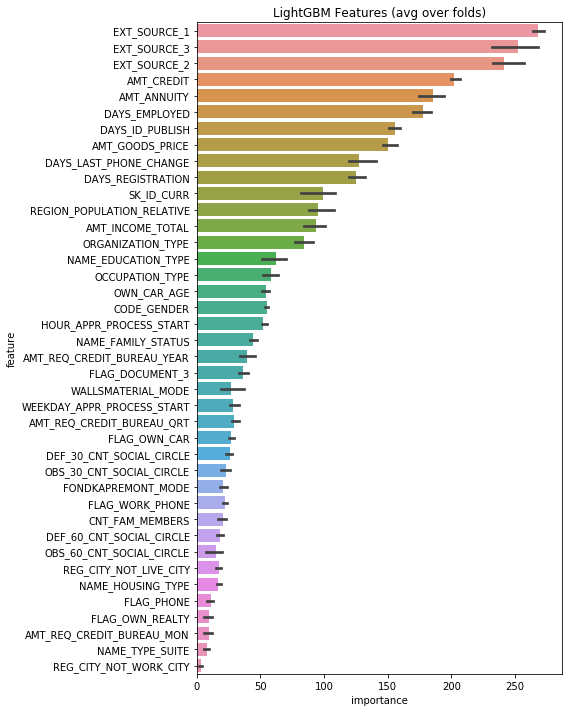

In [23]:
model01, importances01 = kfold_lightgbm(df3, df3_test, num_folds=3, stratified=False, debug=True)

In [24]:
model01

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

【メモ】

- num_leaves <br>
LightGBMで最も重要と言っても過言ではないのがnum_leaves(葉の数)です。num_leavesは決定木の複雑度を調整します。num_leavesの値が高すぎると過学習となり、低すぎると未学習になります。num_leavesを調整する場合はmax_depth（決定木の深さ）のパラメータと一緒に調整すると良いです。

- max_depth <br>
決定木の深さを指定するハイパーパラメータです。単体で調整するよりも、他のハイパーパラメータとのバランスを考えながら調整します。

In [ ]:
# optuna + LightGBM

def objective(trial):

    X_train = df_for_opt.drop(['SK_ID_CURR', 'TARGET'], axis=1)
    y_train = df_for_opt['TARGET']

    train_x, test_x, train_y, test_y = train_test_split(X_train, y_train, test_size=0.3, 
                                                        shuffle=True, stratify=y_train)

    dtrain = lgb.Dataset(train_x, label=train_y)

    param = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        # 'boosting_type': trial.suggest_categorical('boosting', ['gbdt', 'dart', 'goss']),
#         'metric': {'auc'},
#         'verbosity': -1,
        # 'n_estimators': trial.suggest_int('n_estimators', 100, 10000),
#         'n_estimators': 10000,
        # 'boosting_type': trial.suggest_categorical('boosting', ['gbdt', 'dart', 'goss']),
        'num_leaves': trial.suggest_int('num_leaves', 10, 50),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.08, 0.5),
        'max_depth': trial.suggest_int('max_depth', -10, 10),
        # 'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.001, 1.0),
        # 'reg_lambda': trial.suggest_loguniform('reg_lambda', 0.001, 1.0),
        # 'min_split_gain': trial.suggest_loguniform('min_split_gain', 0.001, 1.0),
#         'min_child_weight': trial.suggest_loguniform('min_child_weight', 0.001, 100)
    }

    if param['boosting_type'] == 'dart':
        param['drop_rate'] = trial.suggest_loguniform('drop_rate', 1e-8, 1.0)
        param['skip_drop'] = trial.suggest_loguniform('skip_drop', 1e-8, 1.0)
    if param['boosting_type'] == 'goss':
        param['top_rate'] = trial.suggest_uniform('top_rate', 0.0, 1.0)
        param['other_rate'] = trial.suggest_uniform('other_rate', 0.0, 1.0 - param['top_rate'])

    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(test_x)
    pred_labels = np.rint(preds)

    # accuracy = metrics.accuracy_score(test_y, pred_labels)
    fpr, tpr, thres = metrics.roc_curve(test_y, pred_labels)
    auc = metrics.auc(fpr, tpr)
    
    return auc

df_for_opt = df3

study = optuna.create_study(direction='maximize')  # スコア最大化
study.optimize(objective, n_trials=10)

In [27]:
# 上記をn_trials=1000で実行して、best_valueを出したときのparameterを抽出しましたが、
# 実行結果をクリアしてしまったため、結果のみ下記に記します。

【結果】
- 'num_leaves': 10
- 'learning_rate': 0.4
- 'max_depth': -5

【メモ：デフォルトパラメータ】

LGBMClassifier(
- boosting_type='gbdt', 
- class_weight=None, 
- colsample_bytree=1.0,
- importance_type='split',
- learning_rate=0.1,
- max_depth=-1,
- min_child_samples=20,
- min_child_weight=0.001, 
- min_split_gain=0.0,
- n_estimators=100,
- n_jobs=-1,
- num_leaves=31,
- objective=None,
- random_state=None, 
- reg_alpha=0.0,
- reg_lambda=0.0,
- silent=True,
- subsample=1.0, 
- subsample_for_bin=200000, 
- subsample_freq=0)

In [28]:
def kfold_lightgbm(df, test_df, num_folds, stratified = False, debug= False):
    
    submission_file_name = 'submission_01.csv'
    
    X_train_df = df.drop('TARGET', axis=1)
    y_train_df = df['TARGET']
    X_test_df = test_df
    
    if stratified:
        folds = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=47)
    else:
        folds = KFold(n_splits=num_folds, shuffle=True, random_state=47)
        
    # スコア格納用の配列用意
    oof_preds = np.zeros(X_train_df.shape[0])
    sub_preds = np.zeros(X_test_df.shape[0])
    feature_importance_df = pd.DataFrame()
       
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train_df, y_train_df)):
        X_train, y_train = X_train_df.iloc[train_idx], y_train_df.iloc[train_idx]
        X_valid, y_valid = X_train_df.iloc[valid_idx], y_train_df.iloc[valid_idx]

        # LightGBM
        clf = LGBMClassifier(
            boosting_type='gbdt',
            class_weight=None,
            colsample_bytree=1.0,
            importance_type='split',
            learning_rate=0.4,
            max_depth=-5,
            min_child_samples=20,
            min_child_weight=1.0,
            min_split_gain=0.0,
            n_estimators=350,
            n_jobs=-1,
            num_leaves=10,
            objective=None,
            random_state=None,
            reg_alpha=0.0,
            reg_lambda=0.0,
            silent=True,
            subsample=1.0,
            subsample_for_bin=200000,
            subsample_freq=0
            )

        clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], 
            eval_metric= 'auc', verbose= 1000, early_stopping_rounds=500)

        oof_preds[valid_idx] = clf.predict_proba(X_valid, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(X_test_df, num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = X_train_df.columns
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, metrics.roc_auc_score(y_valid, oof_preds[valid_idx])))
        del X_train, y_train, X_valid, y_valid
        gc.collect()

    print('Full AUC score %.6f' % metrics.roc_auc_score(y_train_df, oof_preds))
    # 提出ファイル出力
    if not debug:
        X_test_df['TARGET'] = sub_preds
        X_test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    return clf, feature_importance_df


def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')

Training until validation scores don't improve for 500 rounds
Did not meet early stopping. Best iteration is:
[350]	training's auc: 0.836059	training's binary_logloss: 0.216097	valid_1's auc: 0.743564	valid_1's binary_logloss: 0.256239
Fold  1 AUC : 0.743564
Training until validation scores don't improve for 500 rounds
Did not meet early stopping. Best iteration is:
[350]	training's auc: 0.83728	training's binary_logloss: 0.216647	valid_1's auc: 0.734618	valid_1's binary_logloss: 0.25563
Fold  2 AUC : 0.734618
Training until validation scores don't improve for 500 rounds
Did not meet early stopping. Best iteration is:
[350]	training's auc: 0.8363	training's binary_logloss: 0.216492	valid_1's auc: 0.738621	valid_1's binary_logloss: 0.254823
Fold  3 AUC : 0.738621
Training until validation scores don't improve for 500 rounds
Did not meet early stopping. Best iteration is:
[350]	training's auc: 0.836054	training's binary_logloss: 0.216898	valid_1's auc: 0.738143	valid_1's binary_logloss: 

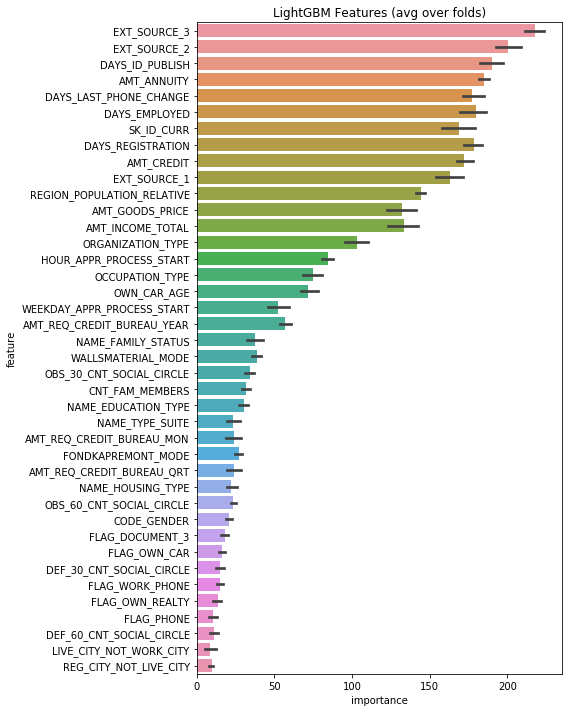

In [29]:
model02, importances02 = kfold_lightgbm(df3.copy(), df3_test.copy(), num_folds=5, stratified=False, debug=False)

## 【問題5】最終的なモデルの選定
最終的にこれは良いというモデルを選び、推定した結果をKaggleに提出してスコアを確認してください。どういったアイデアを取り入れ、どの程度のスコアになったかを記載してください。

### 【提出結果】

- Private Score : 0.73150
- Public Score  : 0.73995